In [6]:
import time
import matplotlib.pyplot as plt
import gym
import numpy as np
import torch
import torch.nn.functional as F
from IPython.display import clear_output, display
from torch import nn, optim

In [7]:
I = 4  # Input dimensions
H = 64  # Hidden layer dimensions
O = 2  # output dimensions (one-hot encoding)
LEARNING_RATE = 0.001
MOMENTUM = 0.9
REPLAY_LENGTH = 1000
EPISODE_NUM = 20000
EPISODE_LENGTH = 200
EPSILON = 0.1
WARMUP_LENGTH = 10
MINIBATCH_SIZE = 1000
# WARMUP_LENGTH = 1
# MINIBATCH_SIZE = 100
EPOCHS = 1
GAMMA = 1
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(I,H)
        self.lin2 = nn.Linear(H,H)
        self.lin3 = nn.Linear(H,O)

    def forward(self, xb):
        xb = F.relu(self.lin1(xb))
        xb = F.relu(self.lin2(xb))
        return self.lin3(xb)

def fit(epochs, batch_size, opt, model, loss_func, x, y):
    for epoch in range(epochs):
        model.train()
        batch_num = x.size()[0] // batch_size
        for i in range(batch_num):
            xb = x[i*batch_size:(i+1)*batch_size]
            yb = y[i*batch_size:(i+1)*batch_size]
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        print(f'Epoch: {epoch}\nLoss: {loss}')

def loss_func(y1, y2):
    return torch.sum(torch.square(y1-y2))

class Replay:
    def __init__(self, n):
        self.rng = np.random.default_rng()
        self.n = n
        self.arr = []

    def debug(self, n):
        print(np.array(self.arr, dtype='object'))
        print(self.rng.choice(np.array(self.arr, dtype='object'), (n,)))

    def sample(self, n):
        minibatch = self.rng.choice(np.array(self.arr, dtype='object'), (n,))
        obs2_arr = torch.from_numpy(np.vstack(minibatch[:, 3])).to(torch.float)
        obs_arr = torch.from_numpy(np.vstack(minibatch[:, 0])).to(torch.float)
        action_arr = torch.from_numpy(np.vstack(minibatch[:, 1]).flatten()).to(torch.long)
        reward_arr = torch.from_numpy(np.vstack(minibatch[:, 2]).flatten()).to(torch.float)
        return obs_arr, action_arr, reward_arr, obs2_arr

    def add_one(self, v):
        self.arr.append(v)
        if len(self.arr) > self.n:
            self.arr.pop(0)

In [9]:
model = DQN()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
replay = Replay(REPLAY_LENGTH)
env = gym.make('CartPole-v0')


KeyboardInterrupt: 

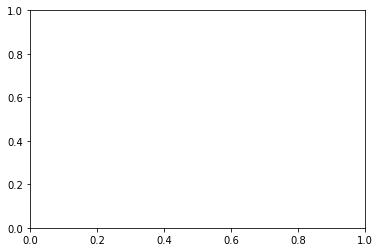

In [10]:
start_time = time.time()
tot_time = 0
reward_history = [0]
fig, ax = plt.subplots()
for episode in range(EPISODE_NUM):
    env.reset()
    obs, reward, done, info = env.step(env.action_space.sample())
    model.eval()
    total_reward = 0
    for t in range(EPISODE_LENGTH):
        if reward_history[-1] > 190:
            env.render()
        obs = torch.from_numpy(obs).type(torch.FloatTensor)
        if np.random.rand() < EPSILON or episode < WARMUP_LENGTH:
            next_action = env.action_space.sample()
        else:
            action_values = model(torch.unsqueeze(obs, 0))[0]
            next_action = torch.argmax(action_values).numpy()
        obs2, reward, done, info = env.step(next_action)
        replay.add_one((obs, next_action, reward, obs2))
        obs = obs2
        total_reward += reward
    reward_history.append(total_reward)
    elapsed_time = time.time() - start_time
    start_time = time.time()
    tot_time += elapsed_time
    print(f'Progress: {episode}/{EPISODE_NUM}\nTime Remaining: {tot_time * (EPISODE_NUM - episode) / (episode + 1)}')
    print(f'Episode {episode}\nreward: {total_reward}')
    if episode >= WARMUP_LENGTH:
        obs_arr, action_arr, reward_arr, obs2_arr = replay.sample(MINIBATCH_SIZE)
        idx = torch.tensor(range(MINIBATCH_SIZE), dtype=torch.long)
        x = obs_arr
        y = model(x)
        y2 = model(obs2_arr)
        y[idx, action_arr] = GAMMA * torch.max(y2, dim=1)[0] + reward_arr
        fit(EPOCHS, MINIBATCH_SIZE, optimizer, model, loss_func, x, y)
    # if episode % 100 == 0:
    #     ax.plot(range(len(reward_history)), reward_history)
    #     display(plt.gcf())
    clear_output(wait=True)



torch.save(model, 'deep_gym_model_v2.pt')

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(reward_history)), reward_history)

In [ ]:
model = torch.load('deep_gym_model_v2.pt')
model.eval()

while(True):
    env.reset()
    obs, reward, done, info = env.step(env.action_space.sample())
    for t in range(EPISODE_LENGTH):
        obs = torch.from_numpy(obs).type(torch.FloatTensor)
        env.render()
        if np.random.rand() < 0:
            next_action = env.action_space.sample()
        else:
            action_values = model(torch.unsqueeze(obs, 0))[0]
            next_action = torch.argmax(action_values).numpy()
        obs2, reward, done, info = env.step(next_action)
        obs = obs2